#Import Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot as plt
%matplotlib inline

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

Num GPUs Available:  1


Import the dataset for Random Forest Classification

In [2]:
df=pd.read_excel("SentimentDatasetonAppReviewfromAppStore.xlsx")
df = df.drop(['ID', 'TITLE', 'RATING'], axis=1)
df[~df.COMMENT.str.contains(r'[0-9]')]
df

,COMMENT,SENTIMEN
0,"Tidak seperti di iphone menunya kurang, jadwal...",Negative
1,Kurang bersahabat ama VoiceOver nih. Semoga ha...,Negative
2,"Hampir setahun belum ada update, UI tidak ada ...",Negative
3,Mohon appnya diperbaiki.. Crashnya ga ketolong...,Negative
4,"Aplikasi sampah, crash mulu,errorny banyak,ga ...",Negative
...,...,...
548,"Aplikasi yg sangat membantu, ada beberapa usul...",Positive
549,Keren gan. Update terus agar lebih lengkap.,Positive
550,Applikasi yang sangat berguna untuk aktifitas ...,Positive
551,"Bagus juga, jadi mudah nyari tempat dan simple...",Positive


In [3]:
df['SENTIMEN'].value_counts()

Positive    259
Negative    241
Neutral      53
Name: SENTIMEN, dtype: int64

In [4]:
# count = 0
# for i in df['SENTIMEN']:
#     if df['SENTIMEN'][count] == 'Neutral':
#         df=df.drop(count)
#     count+=1

In [5]:
# df['SENTIMEN'].value_counts()

Positive    0.468354
Negative    0.435805
Neutral     0.095841
Name: SENTIMEN, dtype: float64

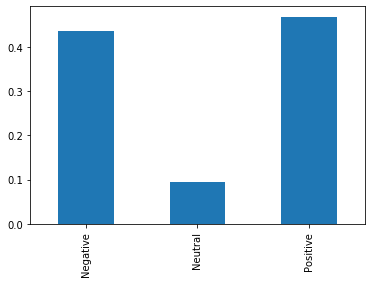

In [6]:
diagram_coba = df.SENTIMEN.value_counts(normalize=True)
diagram_coba[["Negative", "Neutral", "Positive"]].plot(kind="bar")
diagram_coba

#Preprocessing

In [7]:
import re
import string

review_user = df['COMMENT'].astype(str)

#Lower case
review_user = review_user.apply(lambda x: x.lower())

#Remove Number
review_user = review_user.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
review_user = review_user.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
review_user = review_user.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Tokenizing
review_user = review_user.apply(lambda x: nltk.tokenize.word_tokenize(x))

df["COMMENT"] = review_user
df

,COMMENT,SENTIMEN
0,"[tidak, seperti, di, iphone, menunya, kurang, ...",Negative
1,"[kurang, bersahabat, ama, voiceover, nih, semo...",Negative
2,"[hampir, setahun, belum, ada, update, ui, tida...",Negative
3,"[mohon, appnya, diperbaiki, crashnya, ga, keto...",Negative
4,"[aplikasi, sampah, crash, mulu, errorny, banya...",Negative
...,...,...
548,"[aplikasi, yg, sangat, membantu, ada, beberapa...",Positive
549,"[keren, gan, update, terus, agar, lebih, lengkap]",Positive
550,"[applikasi, yang, sangat, berguna, untuk, akti...",Positive
551,"[bagus, juga, jadi, mudah, nyari, tempat, dan,...",Positive


#Train & Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df['COMMENT'], df['SENTIMEN'], test_size=0.2, random_state=42, stratify=df['SENTIMEN'])
X_train


182    [this, app, is, great, but, since, the, last, ...
255    [if, youre, not, online, you, cant, use, the, ...
323    [sepertinya, ada, bug, nih, karena, kalau, tul...
404    [mengecewakan, aplikasinya, ga, bisa, di, paka...
29     [selalu, crash, setiap, mau, mencari, kata, ja...
                             ...                        
199            [tukang, ojek, nya, lama, banget, datang]
233                           [yeap, crash, many, times]
158                             [they, took, my, credit]
436    [tidak, bisa, aktivasi, di, iphone, kembali, i...
488    [gw, demen, in, aps, makasih, sm, yg, bikin, u...
Name: COMMENT, Length: 442, dtype: object

#Import and Vectorize the dataset using the FastText pre-trained model

In [9]:
import gensim
from gensim.models import FastText
loc = "../FastText_models/saved_model_gensim200SG_BYU.bin" #You can change it with your own directory
model = FastText.load(loc)

In [10]:
from CobaVectorizer import MeanEmbeddingVectorizer
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [11]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_val)

In [12]:
X_train_embeddings = X_train_vector
X_test_embeddings = X_test_vector
y_train = y_train.replace(['Positive', 'Neutral', 'Negative'], [1, 0, -1])
y_val = y_val.replace(['Positive', 'Neutral', 'Negative'], [1, 0, -1])
X_train_embeddings

array([[ 0.00854004, -0.04341166, -0.07535776, ...,  0.04635568,
         0.07425904, -0.24877267],
       [ 0.15118721, -0.02331015, -0.00157575, ...,  0.02723662,
         0.10636346, -0.12727994],
       [-0.17017728, -0.1507604 , -0.2032045 , ..., -0.04251852,
         0.02152889, -0.02605511],
       ...,
       [-0.07343431, -0.09138253, -0.12981783, ..., -0.08853858,
        -0.0826005 , -0.40027216],
       [ 0.05572172, -0.11684217, -0.08382049, ..., -0.134581  ,
        -0.04799243, -0.12490673],
       [-0.10720699, -0.09525751, -0.14641182, ...,  0.02186477,
        -0.10714685, -0.23254143]], dtype=float32)

#Classification with Random Forest & Evaluate the model

In [13]:
%%time
from RandomForest import *
np.random.seed(42)
rf_model = RandomForest(samp_size=0.8,
                        num_trees=20,
                        num_features=15,
                        terminate='leaf',
                        leaf_terminate=5,
                        oob=True)

rf_model.fit(X_train_embeddings, y_train)

CPU times: user 1min 44s, sys: 21 ms, total: 1min 44s
Wall time: 1min 44s


In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

y_train_pred = rf_model.predict(X_train_embeddings)
C = confusion_matrix(y_train, y_train_pred)
print(C)

print("Accuracy TRAIN: ", accuracy_score(y_train, y_train_pred))

print(metrics.classification_report(y_train, y_train_pred))

[[193   0   0]
 [  4  38   0]
 [  2   0 205]]
Accuracy TRAIN:  0.9864253393665159
              precision    recall  f1-score   support

          -1       0.97      1.00      0.98       193
           0       1.00      0.90      0.95        42
           1       1.00      0.99      1.00       207

    accuracy                           0.99       442
   macro avg       0.99      0.97      0.98       442
weighted avg       0.99      0.99      0.99       442



In [15]:
y_test_pred = rf_model.predict(X_test_embeddings)
C2 = confusion_matrix(y_val, y_test_pred)
print(C2)
print("Accuracy TEST: ", accuracy_score(y_val, y_test_pred))
print(metrics.classification_report(y_val, y_test_pred))

[[34  0 14]
 [ 4  1  6]
 [ 9  0 43]]
Accuracy TEST:  0.7027027027027027
              precision    recall  f1-score   support

          -1       0.72      0.71      0.72        48
           0       1.00      0.09      0.17        11
           1       0.68      0.83      0.75        52

    accuracy                           0.70       111
   macro avg       0.80      0.54      0.54       111
weighted avg       0.73      0.70      0.68       111



In [16]:
kalimat = [['jelek', 'banget', 'aplikasinya', 'tapi', 'murah', 'harganya', 'lumayanlah']]
test_ya = mean_vec_tr.transform(kalimat)
prediksi = rf_model.predict(test_ya)
if (prediksi==1):
    print("Positive")
elif (prediksi==0):
    print("Neutral")
else:
    print("Negative")

Positive


In [17]:
kalimat2 = [['bagus', 'puas', 'pakenya', 'tapi', 'sayang', 'lemot']]
test_ya2 = mean_vec_tr.transform(kalimat2)
prediksi2 = rf_model.predict(test_ya2)
if (prediksi2==1):
    print("Positive")
elif (prediksi2==0):
    print("Neutral")
else:
    print("Negative")

Positive


In [18]:
# %%time
# n_pohon = [20, 15, 10]
# n_features = [15, int(np.sqrt(X_train_embeddings.shape[1]))]
# min_leaf = [5, 7, 9]
# sample_size = [0.5, 0.8]
# acu_train = 0
# acu_test = 0

# for pohon in n_pohon:
#     for sample in sample_size:
#         for leaf in min_leaf:
#             for fitur in n_features:
#                 np.random.seed(42)
#                 coba_RF = RandomForest(samp_size=sample, num_trees=pohon, num_features=fitur,
#                                       terminate='leaf', leaf_terminate=leaf, oob=True)
#                 coba_RF.fit(X_train_embeddings, y_train)
#                 train_coba = coba_RF.predict(X_train_embeddings)
#                 test_coba = coba_RF.predict(X_test_embeddings)
#                 acu_train_temp = accuracy_score(y_train, train_coba)
#                 acu_test_temp = accuracy_score(y_val, test_coba)
#                 if(acu_test_temp > acu_test):
#                     acu_train = acu_train_temp
#                     acu_test = acu_test_temp
#                     print("n_tree: ", pohon)
#                     print("Sample Size: ", sample)
#                     print("Leaf: ", leaf)
#                     print("Max features: ", fitur)
#                     print("TRAIN Accuracy: ", acu_train)
#                     print("TEST Accuracy: ", acu_test)
#                     print("=========================")